In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
import tensorflow as tf

In [ ]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cat

In [ ]:
from typing import List
from tqdm import tqdm
import warnings
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [ ]:
class DataModeler:
    def __init__(self):
        pass

    def _parametrized(dec):
        def layer(*args, **kwargs):
            def repl(f):
                return dec(f, *args, **kwargs)
            return repl
        return layer

    @staticmethod
    @_parametrized
    def logger(f, job):
        def aux(self, *xs, **kws):
            print(job + "...", end='\t')
            res = f(self, *xs, **kws)
            print("Done")
            return res
        return aux

In [ ]:
class DataPreprocessor(DataModeler):
    "Wrap the operations of data preprocessing."
    
    def __init__(self):
        super(DataPreprocessor, self).__init__()

    @DataModeler.logger("Foramtting feature namne")
    def _format_feat_name(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Format feature name
        @param df: Dataframe
        return: precessed dataframe
        """
        d = {x:'_'.join(x.split()) for x in df.columns}
        df = df.rename(columns=d)
        return df

    @DataModeler.logger("Filling missing value")
    def _fill_missing_value(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Fill missing values in input data.
        @param df: dataframe
        return: processed dataframe
        """
        res = df.fillna(method='ffill')

        return res
    

    @DataModeler.logger("Transforming feature type")
    def _trans_feat_type(self, df_energy:pd.DataFrame, df_weather:pd.DataFrame) -> List[pd.DataFrame]:
        """
        Transform data type of some columns.
        @param df_energy: energy data
        @param df_weather: weather data
        return: processed data
        """
        df_energy['time'] = pd.to_datetime(df_energy['time'])
        df_weather['time'] = pd.to_datetime(df_weather['time'])

        return df_energy, df_weather


    @DataModeler.logger("Combining weather data")
    def _combine_weather_data(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Combine weather data from different cities so that 
            it can be joined on the energy data.
        @param df: dataframe
        return: processed dataframe
        """
        num_feats = [
            'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 
            'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 
            'snow_3h', 'clouds_all'
        ]
        res = df[num_feats+['time']].groupby(['time'], as_index=False).mean()
        
        return res
    
    def preprocess(self, df_energy_:pd.DataFrame, df_weather_:pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess energy data and weather data and then join them together.
        @param df_energy_: energy data
        @param df_weather_: weather data
        return: combined clean energy and weather data
        """
        df_energy = df_energy_.copy()
        df_weather = df_weather_.copy()
        df_weather = df_weather.rename(columns={'dt_iso':'time'})

        #* Fill missing value
        df_energy = self._fill_missing_value(df_energy)

        #* Drop invalid columns
        cols_to_drop = ['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'] +\
                        ['generation fossil coal-derived gas', 'generation wind offshore', 'generation fossil oil shale', 
                        'generation fossil peat', 'generation geothermal', 'generation marine']
        df_energy = df_energy.drop(cols_to_drop, axis=1)

        #* Combine weather data
        df_weather = self._combine_weather_data(df_weather)

        #* Join energy data and weather data
        df = pd.merge(df_energy, df_weather, on=['time'])
        df['time'] = pd.to_datetime(df['time'], utc=True)
        df = df.sort_values(by='time', ascending=True).reset_index(drop=True)

        #* Format feature name
        df = self._format_feat_name(df)

        df = df.set_index('time')
        df['price_tomorrow'] = df['price_actual'].shift(-1, freq='D')
        df = df.iloc[:-24]
        df = df.reset_index()
        return df

In [ ]:
class FeatureEngineer(DataModeler):
    "Wrap the operations of feature engineering."
    
    def __init__(self):
        super(FeatureEngineer, self).__init__()
    
    @DataModeler.logger("Generating date features")
    def _gen_date_feats(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Extract date features from time of data
        @param df: Dataframe
        return:  dataframe with new features
        """
        df["year"]=df['time'].dt.year
        df["quarter"]=df['time'].dt.quarter
        df["month"]=df['time'].dt.month
        df["week"]=df['time'].dt.week
        df["hour"]=df['time'].dt.hour
        df['dayofweek'] = df['time'].dt.dayofweek
        df["dayofmonth"]=df['time'].dt.day
        df['is_weekend'] = np.where(df['time'].dt.day_name().isin(['Sunday', 'Saturday']), 1,0)
        df["is_year_start"]=df['time'].dt.is_year_start

        return df

    @DataModeler.logger("Generating historical features")
    def _gen_his_feats(self, df:pd.DataFrame, cols:List[str], lag_len:int, unit:str='D'):
        """
        Use historical data as new feature.
        @param df: Dataframe
        @param cols: Columns to be used
        @param lag_len: length of lag
        @param unit: unit of `lag_len`, default 'D' day
        """
        df = df.set_index('time')
        
        new_cols = [f'{x}__{lag_len}{unit}_ahead' for x in cols]
        df[new_cols] = df[cols].shift(lag_len, freq=unit)
        df[new_cols] = df[new_cols].fillna(method='bfill')
        
        df = df.reset_index()
        return df

    @DataModeler.logger("Generating groupby features")
    def _gen_groupby_feats(self, df:pd.DataFrame, col:str, groupby_cols:List[str], method) -> pd.DataFrame:
        """
        Generate groupby features
        @param df: Dataframe
        @param col: target column
        @param groupby_cols: Categorical features used for groupby
        @param method: aggregate method
        """
        df_tmp = df[groupby_cols+[col]].copy()
        df_tmp = df_tmp.groupby(groupby_cols,as_index=False)[col].agg([method])
        df_tmp = df_tmp.rename(columns={method: '_'.join(groupby_cols)+'__'+ col +'__'+method})
        df = pd.merge(df, df_tmp, on=groupby_cols, how='left')
        return df

    @DataModeler.logger("Generating sliding window features")
    def _gen_slide_window_feats(self, df:pd.DataFrame, cols:List[str], width:str) -> pd.DataFrame:
        """
        Use sliding window to generate features
        @param df: Dataframe
        @param cols: Target columns
        @param width: window width, e.g. '2D'
        return: dataframe with new features
        """
        df = df.set_index('time')
        
        new_cols = [f'{x}__{width}_sw' for x in cols]
        df[new_cols] = df[cols].rolling(width, min_periods=0, closed='left').mean()
        df[new_cols] = df[new_cols].fillna(method='bfill')

        df = df.reset_index()
        return df

    def generate_feats(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Generate new features.
        @param df: dataframe
        return: dataframe with new features
        """
        df = self._gen_date_feats(df)

        df = self._gen_his_feats(df, ['price_actual'], lag_len=31, unit='D')
        df = self._gen_groupby_feats(df, 'price_actual__31D_ahead', ['year', 'month'], 'mean')
        df = self._gen_groupby_feats(df, 'price_actual__31D_ahead', ['year', 'month'], 'min')
        df = self._gen_groupby_feats(df, 'price_actual__31D_ahead', ['year', 'month'], 'max')
        df = self._gen_groupby_feats(df, 'price_actual__31D_ahead', ['year', 'month', 'week'], 'mean')
        df = self._gen_groupby_feats(df, 'price_actual__31D_ahead', ['year', 'month', 'week'], 'min')
        df = self._gen_groupby_feats(df, 'price_actual__31D_ahead', ['year', 'month', 'week'], 'max')
        
        df = self._gen_his_feats(df, ['price_actual'], lag_len=7, unit='D')
        df = self._gen_groupby_feats(df, 'price_actual__7D_ahead', ['year', 'month'], 'mean')
        df = self._gen_groupby_feats(df, 'price_actual__7D_ahead', ['year', 'month'], 'min')
        df = self._gen_groupby_feats(df, 'price_actual__7D_ahead', ['year', 'month'], 'max')

        df = self._gen_his_feats(df, ['price_actual'], lag_len=1, unit='D')
        df = self._gen_his_feats(df, ['price_actual'], lag_len=1, unit='H')

        df = self._gen_slide_window_feats(df, ['price_actual'], '1H')
        df = self._gen_slide_window_feats(df, ['price_actual'], '6H')
        df = self._gen_slide_window_feats(df, ['price_actual'], '12H')
        df = self._gen_slide_window_feats(df, ['price_actual'], '1D')
        df = self._gen_slide_window_feats(df, ['price_actual'], '7D')
        df = self._gen_slide_window_feats(df, ['price_actual'], '3D')
        df = self._gen_slide_window_feats(df, ['price_actual'], '7D')
        df = self._gen_slide_window_feats(df, ['price_actual'], '14D')
        df = self._gen_slide_window_feats(df, ['price_actual'], '31D')
        
        df = self._gen_slide_window_feats(df, ['temp'], '1H')
        df = self._gen_slide_window_feats(df, ['temp'], '6H')
        df = self._gen_slide_window_feats(df, ['temp'], '12H')
        df = self._gen_slide_window_feats(df, ['temp'], '1D')
        df = self._gen_slide_window_feats(df, ['temp'], '7D')
        
        df = self._gen_slide_window_feats(df, ['pressure'], '1H')
        df = self._gen_slide_window_feats(df, ['pressure'], '6H')
        df = self._gen_slide_window_feats(df, ['pressure'], '12H')
        df = self._gen_slide_window_feats(df, ['pressure'], '1D')
        df = self._gen_slide_window_feats(df, ['pressure'], '7D')
        
        df = self._gen_slide_window_feats(df, ['humidity'], '1H')
        df = self._gen_slide_window_feats(df, ['humidity'], '6H')
        df = self._gen_slide_window_feats(df, ['humidity'], '12H')
        df = self._gen_slide_window_feats(df, ['humidity'], '1D')
        df = self._gen_slide_window_feats(df, ['humidity'], '7D')
        
        df = self._gen_slide_window_feats(df, ['wind_speed'], '1H')
        df = self._gen_slide_window_feats(df, ['wind_speed'], '6H')
        df = self._gen_slide_window_feats(df, ['wind_speed'], '12H')
        df = self._gen_slide_window_feats(df, ['wind_speed'], '1D')
        df = self._gen_slide_window_feats(df, ['wind_speed'], '7D')

        return df
    
    @staticmethod
    def select_feats(df:pd.DataFrame, feats:List[str], target:str) -> List[str]:
        """
        Select faetures to be trained
        @param df: Dataframe
        @param feats: All features
        @param target: Target column name
        return: List of features to be used for training
        """
        drop_l = [
            'humidity__12H_sw',
            'generation_other',
            'year_month__price_actual__31D_ahead__min',
            'year_month__price_actual__31D_ahead__mean',
            'generation_hydro_pumped_storage_consumption',
            'month',
            'price_actual__1H_sw',
            'humidity__6H_sw',
            'generation_hydro_water_reservoir',
            'temp_max',
            'clouds_all',
            'temp__6H_sw',
            'humidity',
            'wind_deg',
            'is_weekend',
            'quarter',
            'wind_speed',
            'temp',
            'wind_speed__1H_sw',
            'humidity__1H_sw',
            'year',
            'temp__1H_sw',
            'rain_1h',
            'temp_min',
            'rain_3h',
            'snow_3h',
            'is_year_start'
        ]
        res = [x for x in feats if x not in drop_l]

        return res

In [ ]:
class Learner(DataModeler):
    def __init__(self):
        super(Learner, self).__init__()

        self.model_dict = {
            'LR':    {'class':LinearRegression,      'model':[]},
            'Ridge': {'class':Ridge,                 'model':[]},
            'Lasso': {'class':Lasso,                 'model':[]},
            'RF':    {'class':RandomForestRegressor, 'model':[]},
            'SVM':   {'class':SVR,                   'model':[]},
            'LGB':   {'class':None,                  'model':[]},
            'XGB':   {'class':None,                  'model':[]},
            'CAT':   {'class':None,                  'model':[]}
        }
        self.scaler = None
    
    def _lgb_train(self, train_x:pd.DataFrame, train_y:pd.DataFrame, valid_x:pd.DataFrame, valid_y:pd.DataFrame, params:dict):
        """
        
        Train LGB models
        @param train_x: training data
        @param train_y: training label
        @param valid_x: validating data
        @param valid_y: validating label
        @param params: LGB model parameters
        """
        trn_data = lgb.Dataset(train_x, label=train_y)
        val_data = lgb.Dataset(valid_x, label=valid_y)
        model = lgb.train(
            params, 
            trn_data, 
            10000, 
            valid_sets = [trn_data, val_data], 
            verbose_eval=500, 
            early_stopping_rounds = 20
        )
        valid_pred = model.predict(valid_x, num_iteration=model.best_iteration)

        return model, valid_pred
    
    def _xgb_train(self, train_x:pd.DataFrame, train_y:pd.DataFrame, valid_x:pd.DataFrame, valid_y:pd.DataFrame, params:dict):
        """
        Train XGB models
        @param train_x: training data
        @param train_y: training label
        @param valid_x: validating data
        @param valid_y: validating label
        @param params: LGB model parameters
        """
        trn_data = xgb.DMatrix(train_x, train_y)
        val_data = xgb.DMatrix(valid_x, valid_y)

        watchlist = [(trn_data, 'train'), (val_data, 'valid')]
        model = xgb.train(dtrain=trn_data, num_boost_round=10000, 
                        evals=watchlist, early_stopping_rounds=20,
                        verbose_eval=500, params=params)

    
        valid_pred = model.predict(xgb.DMatrix(valid_x), ntree_limit=model.best_ntree_limit)

        return model, valid_pred

    def _cat_train(self, train_x:pd.DataFrame, train_y:pd.DataFrame, valid_x:pd.DataFrame, valid_y:pd.DataFrame, params:dict):
        """
        Train CatBoost models
        @param train_x: training data
        @param train_y: training label
        @param valid_x: validating data
        @param valid_y: validating label
        @param params: LGB model parameters
        """
        model = cat.CatBoostRegressor(iterations=20000, **params)
        model.fit(
            train_x, train_y, 
            eval_set=(valid_x, valid_y),
            # cat_features=cat_feats,
            use_best_model=True, 
            verbose=500
        )

        valid_pred = model.predict(valid_x)

        return model, valid_pred


    def train(self, df_:pd.DataFrame, target:str, feats:List[str], nfold:int, model_name:str, model_param:dict, metric_func, val_idx=None):
        """
        Train models
        @param df_: trainset
        @param target: predicting target column name
        @param nfold: cross validation fold number
        @param feats: features to be used for training model
        @param model_name: model name, must be one of keys in model_dict
        @param model_param: model parameter dict
        @param metric_func: metric function
        @param val_idx: valid set index, if None then choose the last 1/4 data
        """
        assert model_name in self.model_dict.keys(), f"{model_name} is not supported"
        
        metric_l = []
        self.model_dict[model_name]['model'] = []

        df = df_.copy()
        if self.scaler is None:
            self.scaler = MinMaxScaler().fit(df[feats])
        df[feats] = self.scaler.transform(df[feats])

        if val_idx is None:
            val_rate = 0.25
            train_x = df.iloc[:-int(df.shape[0]*val_rate)][feats]
            train_y = df.iloc[:-int(df.shape[0]*val_rate)][target]
            valid_x = df.iloc[-int(df.shape[0]*val_rate):][feats]
            valid_y = df.iloc[-int(df.shape[0]*val_rate):][target]
        else:
            train_x = df[~val_idx][feats]
            train_y = df[~val_idx][target]
            valid_x = df[val_idx][feats]
            valid_y = df[val_idx][target]
    
        if model_name not in ['LGB', 'XGB', 'CAT']:
            model = self.model_dict[model_name]['class'](**model_param).fit(train_x, train_y)
            valid_pred = model.predict(valid_x)
        elif model_name == 'LGB':
            model, valid_pred = self._lgb_train(train_x, train_y, valid_x, valid_y, model_param)
        elif model_name == 'XGB':
            model, valid_pred = self._xgb_train(train_x, train_y, valid_x, valid_y, model_param)
        elif model_name == 'CAT':
            model, valid_pred = self._cat_train(train_x, train_y, valid_x, valid_y, model_param)
        
        metric = metric_func(valid_y, valid_pred)
        metric_l.append(metric)
        self.model_dict[model_name]['model'].append(model)
        
        print(f"{model_name} End of training, avg metric: {np.mean(metric_l)}")
    
    def _single_predict(self, df:pd.DataFrame, feats:List[str], model_name:str) -> np.array:
        """
        Use single model to predict
        @param df: testset
        @param feats: features used for training mdoel
        @param model_name: model name, must be one of keys in model_dict and has been trained
        return: prediction
        """
        pred_l = []
        weights = [1]

        for i,model in enumerate(self.model_dict[model_name]['model']):
            if model_name not in ['LGB', 'XGB', 'CAT']:
                pred_l.append((model.predict(df[feats].values) * weights[i]).tolist())
            elif model_name == 'LGB':
                pred_l.append((model.predict(df[feats].values, num_iteration=model.best_iteration) * weights[i]).tolist())
            elif model_name == 'XGB':
                pred_l.append((model.predict(xgb.DMatrix(df[feats]), ntree_limit=model.best_ntree_limit) * weights[i]).tolist())
            elif model_name == 'CAT':
                pred_l.append((model.predict(df[feats]) * weights[i]).tolist())

        pred = np.sum(np.array(pred_l), axis=0)
        return pred
    
    def predict(self, df_:pd.DataFrame, feats:List[str], models:List[str]=None, weights:List[float]=None) -> np.array:
        """
        Use all the models that have been trained before to predict
        @param df: testset
        @param feats: features used for training mdoel
        @param models: dict of model names to predict {model_name:weight}, if None then use all models
        return: prediction
        """
        df = df_.copy()
        df[feats] = self.scaler.transform(df[feats])

        if models is not None:
            for m in models:
                assert m in self.model_dict.keys() and len(self.model_dict[m]['model'])>0, f"{m} is not trained."

        pred_l = []
        if models is None:
            models = [x for x in self.model_dict.keys() if len(self.model_dict[x]['model'])>0]
        if weights is None:
            weights = [1/len(models) for _ in models] # if model weight is not assigned then avg the model output
        
        for i,model in tqdm(enumerate(models), "Predicting"):
            tmp = self._single_predict(df, feats, model) * weights[i]
            pred_l.append(tmp.tolist())
        
        pred = np.sum(np.array(pred_l), axis=0)
        return pred

In [ ]:
# Dataset Link: https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather
data_dir = '/content/drive/MyDrive/DS 5110 Final Project/data/'
df_energy = pd.read_csv(data_dir + 'energy_dataset.csv')
df_weather = pd.read_csv(data_dir + 'weather_features.csv')

In [ ]:
data_preprocessor = DataPreprocessor()
df = data_preprocessor.preprocess(df_energy, df_weather)

Filling missing value...	Done
Combining weather data...	Done
Foramtting feature namne...	Done


In [ ]:
feat_engineer = FeatureEngineer()
df = feat_engineer.generate_feats(df)

Generating date features...	Done
Generating historical features...	Done
Generating groupby features...	Done
Generating groupby features...	Done
Generating groupby features...	Done
Generating groupby features...	Done
Generating groupby features...	Done
Generating groupby features...	Done
Generating historical features...	Done
Generating groupby features...	Done
Generating groupby features...	Done
Generating groupby features...	Done
Generating historical features...	Done
Generating historical features...	Done
Generating sliding window features...	Done
Generating sliding window features...	Done
Generating sliding window features...	Done
Generating sliding window features...	Done
Generating sliding window features...	Done
Generating sliding window features...	Done
Generating sliding window features...	Done
Generating sliding window features...	Done
Generating sliding window features...	Done
Generating sliding window features...	Done
Generating sliding window features...	Done
Generating sli

In [ ]:
drop_feats = ['time', 'forecast_solar_day_ahead', 'forecast_wind_onshore_day_ahead', 'total_load_forecast', 'price_day_ahead', 'price_tomorrow']
feats = [x for x in df.columns if x not in drop_feats]

target = 'price_tomorrow'

In [ ]:
related_feats = FeatureEngineer.select_feats(df, feats, target)

In [ ]:
test_idx = df['time'].dt.year==2018 # & (df['time'].dt.month.apply(lambda x: x in [9,10,11,12]))
df_train = df[~test_idx].reset_index(drop=True)
df_test = df[test_idx].reset_index(drop=True)

In [ ]:
# plt.figure(figsize=(30,5))
# ax = plt.subplot(111)
# sns.lineplot(x='time', y=target, data=df, color='#404040', linewidth = 0.5, ax=ax)
# ax.axvline(pd.to_datetime('2017-04-02'), color='orange', lw=2)
# ax.axvline(pd.to_datetime('2017-12-31'), color='orange', lw=2)
# plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2018-12-31'))
# plt.savefig(data_dir+'price.png', dpi=600)

In [ ]:
lgb_params = {
    'bagging_freq': 1,
    'bagging_fraction': 0.9,
    'bagging_seed': 2021,
    'boost': 'gbdt',
    'feature_fraction': 0.8,
    'feature_fraction_seed': 2021,
    'learning_rate': 0.001,
    'max_depth': 6,  
    'metric':'mse',
    # 'min_data_in_leaf': 20,
    # 'num_leaves': 64,
    'objective': 'regression', 
    "lambda_l1": 0.1,
    'lambda_l2': 1.
}
xgb_params = {
    'booster':'gbtree',
    'objective': 'reg:squarederror',
    'gamma':0.1,
    'lambda':1.0,
    'max_depth':6,
    'subsample':0.9,
    'colsample_bytree':0.8,
    'colsample_bylevel':0.9,
    'eta': 0.001,
    'seed':2021,
    'silent':1,
}
cat_params = {
    'learning_rate': 0.001, 
    'depth': 6, 
    'l2_leaf_reg': 1, 
    'bootstrap_type': 'Bernoulli',
    'od_type': 'Iter', 
    'od_wait': 20,
    'random_seed': 2021, 
    'allow_writing_files': False
}

In [ ]:
learner = Learner()
learner.train(df_train, target, feats, 5, 'LGB', lgb_params, mean_squared_error) # 32.1

Training until validation scores don't improve for 20 rounds.
[500]	training's l2: 120.223	valid_1's l2: 62.5124
[1000]	training's l2: 71.479	valid_1's l2: 44.7288
[1500]	training's l2: 50.2624	valid_1's l2: 37.4961
[2000]	training's l2: 39.6125	valid_1's l2: 34.4915
[2500]	training's l2: 33.4872	valid_1's l2: 33.1098
[3000]	training's l2: 29.4641	valid_1's l2: 32.3765
Early stopping, best iteration is:
[3332]	training's l2: 27.431	valid_1's l2: 32.1223
LGB End of training, avg metric: 32.12234039775199


In [ ]:
feature_importance_df = pd.DataFrame()
feature_importance_df["Feature"] = feats
feature_importance_df["importance"] = learner.model_dict['LGB']['model'][0].feature_importance()
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [ ]:
feature_importance_df[feature_importance_df.index>=50]['Feature'].values.tolist()

['humidity__12H_sw',
 'generation_other',
 'year_month__price_actual__31D_ahead__min',
 'year_month__price_actual__31D_ahead__mean',
 'generation_hydro_pumped_storage_consumption',
 'month',
 'price_actual__1H_sw',
 'humidity__6H_sw',
 'generation_hydro_water_reservoir',
 'temp_max',
 'clouds_all',
 'temp__6H_sw',
 'humidity',
 'wind_deg',
 'is_weekend',
 'quarter',
 'wind_speed',
 'temp',
 'wind_speed__1H_sw',
 'humidity__1H_sw',
 'year',
 'temp__1H_sw',
 'rain_1h',
 'temp_min',
 'rain_3h',
 'snow_3h',
 'is_year_start']

In [ ]:
learner = Learner()
learner.train(df_train, target, related_feats, 5, 'LR', {}, mean_squared_error) # 43.9
learner.train(df_train, target, related_feats, 5, 'Ridge', {'alpha':0.05}, mean_squared_error) # 43.8
learner.train(df_train, target, related_feats, 5, 'Lasso', {'alpha':0.05}, mean_squared_error) # 39.8
learner.train(df_train, target, related_feats, 5, 'RF', {}, mean_squared_error) # 34
learner.train(df_train, target, related_feats, 5, 'LGB', lgb_params, mean_squared_error) # 32.1
learner.train(df_train, target, related_feats, 5, 'XGB', xgb_params, mean_squared_error) # 31.6
learner.train(df_train, target, related_feats, 5, 'CAT', cat_params, mean_squared_error) # 31.2

LR End of training, avg metric: 41.329093039715545
Ridge End of training, avg metric: 41.316420987698926
Lasso End of training, avg metric: 41.63496761073375
RF End of training, avg metric: 33.80721811965177
Training until validation scores don't improve for 20 rounds.
[500]	training's l2: 120.087	valid_1's l2: 62.5104
[1000]	training's l2: 71.4131	valid_1's l2: 44.6443
[1500]	training's l2: 50.207	valid_1's l2: 37.4091
[2000]	training's l2: 39.5898	valid_1's l2: 34.4032
[2500]	training's l2: 33.4855	valid_1's l2: 33.0699
[3000]	training's l2: 29.4656	valid_1's l2: 32.3972
Early stopping, best iteration is:
[3179]	training's l2: 28.322	valid_1's l2: 32.2459
LGB End of training, avg metric: 32.24591339461331
[0]	train-rmse:56.9408	valid-rmse:58.2484
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[500]	train-rmse:34.9853	valid-rmse:35.7492
[1000]	train-rmse:21.7953	valid-rmse:22.2666
[1500]	

In [ ]:
lr_pred = learner.predict(df_test, related_feats, ['LR']) # 6.98271560973388
print(mean_squared_error(df_test[target], lr_pred, squared=False))
ridge_pred = learner.predict(df_test, related_feats, ['Ridge']) # 6.98271560973388
print(mean_squared_error(df_test[target], ridge_pred, squared=False))
lasso_pred = learner.predict(df_test, related_feats, ['Lasso']) # 6.98271560973388
print(mean_squared_error(df_test[target], lasso_pred, squared=False))
rf_pred = learner.predict(df_test, related_feats, ['RF']) # 6.98271560973388
print(mean_squared_error(df_test[target], rf_pred, squared=False))
lgb_pred = learner.predict(df_test, related_feats, ['LGB']) # 6.98271560973388
print(mean_squared_error(df_test[target], lgb_pred, squared=False))
xgb_pred = learner.predict(df_test, related_feats, ['XGB']) # 6.393915538872442
print(mean_squared_error(df_test[target], xgb_pred, squared=False))
cat_pred = learner.predict(df_test, related_feats, ['CAT']) # 6.393915538872442
print(mean_squared_error(df_test[target], cat_pred, squared=False))

Predicting: 1it [00:00, 86.88it/s]


7.00886016095152


Predicting: 1it [00:00, 88.99it/s]


7.006245377352049


Predicting: 1it [00:00, 96.72it/s]


6.762260238548195


Predicting: 1it [00:00,  4.06it/s]


6.471711162865071


Predicting: 1it [00:01,  1.73s/it]


6.272915974433108


Predicting: 1it [00:04,  4.05s/it]


6.432455147833062


Predicting: 1it [00:00, 16.26it/s]

6.201253128364621


In [ ]:
pred = learner.predict(df_test, related_feats, ['LR','Ridge','Lasso','RF'])
mean_squared_error(df_test[target], pred, squared=False)

Predicting: 4it [00:00, 13.28it/s]


6.366028471931358

In [ ]:
pred = learner.predict(df_test, related_feats, ['LGB','XGB','CAT','LR','Ridge','Lasso','RF'], [0.15, 0.15, 0.2, 0.125, 0.125, 0.125, 0.125])
mean_squared_error(df_test[target], pred, squared=False) # 6.08

Predicting: 7it [00:06,  1.14it/s]


6.118972388436285

In [ ]:
mean_squared_error(df_test[target], np.ones_like(df_test[target].values) * np.mean(df_train[target]), squared=False)

14.20246244284816

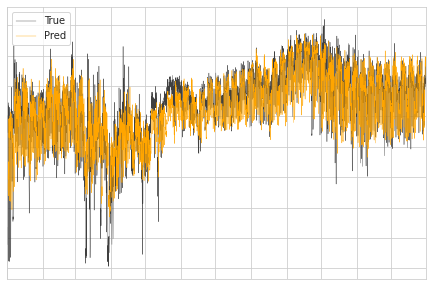

In [ ]:
plt.figure(figsize=(7.5,5))
ax = plt.subplot(111)
sns.lineplot(x=df_test['time'].values, y=df_test[target].values, label='True', ax=ax, color='#404040',linewidth = 0.4)
sns.lineplot(x=df_test['time'].values, y=pred, label='Pred', ax=ax, color='orange',linewidth = 0.4)
plt.xlim(pd.to_datetime('2018-01-01'), pd.to_datetime('2018-12-31'))
ax.set(xticklabels=[])
ax.set(yticklabels=[])
plt.savefig(data_dir+'pred.png',dpi=600)

In [ ]:
pd.options.display.max_rows = None
feature_importance_df = pd.DataFrame()
feature_importance_df["Feature"] = feats
feature_importance_df["importance"] = learner.model_dict['LGB']['model'][0].feature_importance()
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
feature_importance_df